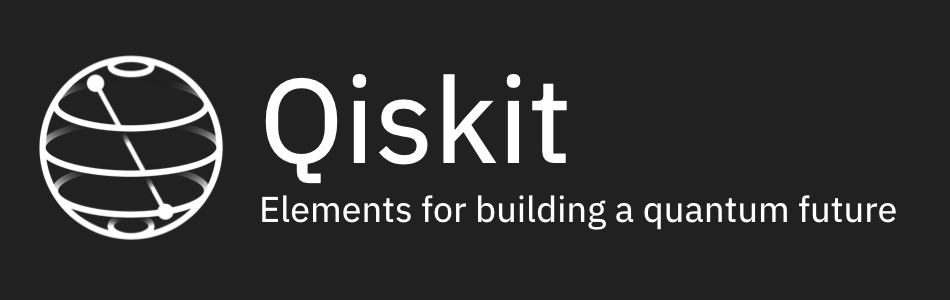

# Circuit Runner

This tutorial introduces the Qiskit Runtime program `circuit-runner`. 

`circuit-runner` is a program that takes in one or more circuits, compiles them, executes them, and optionally applies measurement error mitigation. The program metadata tells you what the inputs and outputs are:

In [1]:

from qiskit import IBMQ

IBMQ.load_account()
provider = IBMQ.get_provider(project='qiskit-runtime')  # Change this to your provider.
program = provider.runtime.program('circuit-runner')
print(program)

circuit-runner:
  Name: circuit-runner
  Description: A runtime program that takes one or more circuits, compiles them, executes them, and optionally applies measurement error mitigation.
  Version: 1
  Creation date: 2021-05-05T20:21:31Z
  Max execution time: 1800
  Parameters:
    - circuits:
      Description: A circuit or a list of circuits.
      Type: A QuantumCircuit or a list of QuantumCircuits.
      Required: True
    - initial_layout:
      Description: Initial position of virtual qubits on physical qubits.
      Type: dict or list
      Required: False
    - layout_method:
      Description: Name of layout selection pass ('trivial', 'dense', 'noise_adaptive', 'sabre')
      Type: string
      Required: False
    - routing_method:
      Description: Name of routing pass ('basic', 'lookahead', 'stochastic', 'sabre').
      Type: string
      Required: False
    - translation_method:
      Description: Name of translation pass ('unroller', 'translator', 'synthesis').
      Typ

The following is an example of running a circuit using `circuit-runner`. First we prepare the initial state:

In [2]:
import numpy as np

k = 5
state = (1/np.sqrt(8))*np.array([np.exp(-1j*2*np.pi*k*(0)/8),np.exp(-1j*2*np.pi*k*(1)/8),
                                 np.exp(-1j*2*np.pi*k*(2)/8),
 np.exp(-1j*2*np.pi*k*3/8),np.exp(-1j*2*np.pi*k*4/8),np.exp(-1j*2*np.pi*k*5/8),
 np.exp(-1j*2*np.pi*k*6/8), np.exp(-1j*2*np.pi*k*7/8)])

We then construct and show the circuit:

In [3]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Statevector

qubits = 3 

circuit = QuantumCircuit(qubits, qubits)
circuit.initialize(state)
circuit.append(QFT(qubits), range(qubits))
circuit.measure(range(qubits), range(qubits))

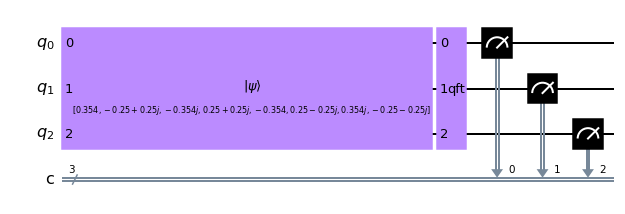

In [4]:
circuit.draw(output="mpl")

Now let's run this circuit using the `circuit-runner` program. Note that `circuit-runner` has its own result decoder in `RunnerResult`, so you'll need to pass that when getting the job result: 

In [5]:
from qiskit_runtime.circuit_runner import RunnerResult

backend = provider.backend.ibmq_montreal

runtime_inputs = {
    'circuits': circuit,
    'optimization_level': 3
}
options = {'backend_name': backend.name()}
job = provider.runtime.run(program_id="circuit-runner",
                           options=options,
                           inputs=runtime_inputs,
                          )
print(f"job ID: {job.job_id()}")
result = job.result(decoder=RunnerResult)

job ID: c29j4a418tu3tem8ffng


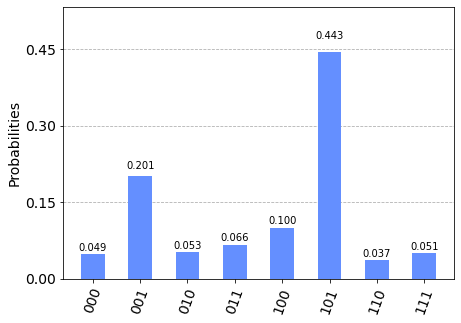

In [6]:
from qiskit.visualization import plot_histogram

counts = result.get_counts()
plot_histogram(counts)

You can also choose to have measurement error mitigation automatically applied when the circuit execution finishes:

In [7]:
from qiskit_runtime.circuit_runner import RunnerResult

backend = provider.backend.ibmq_montreal

runtime_inputs = {
    'circuits': circuit,
    'optimization_level': 3,
    'measurement_error_mitigation': True
}
options = {'backend_name': backend.name()}
job = provider.runtime.run(program_id="circuit-runner",
                           options=options,
                           inputs=runtime_inputs,
                          )
print(f"job ID: {job.job_id()}")
result = job.result(decoder=RunnerResult)

job ID: c29j4fc18tu3tem8ffog


Applying measurement error mitigation to the circuit execution output will result in a vector that does not correspond to a probability distribution. Because of this we call the mitigated probabilities *quasi-probabilities*:

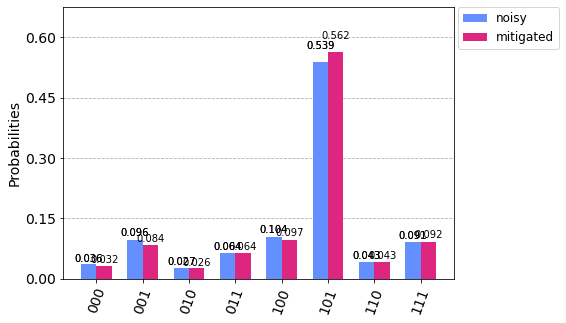

In [8]:
noisy = result.get_counts()
mitigated = result.get_quasiprobabilities().nearest_probability_distribution()
plot_histogram([noisy, mitigated], legend=['noisy', 'mitigated'])

In addition to using the `run()` method to invoke `circuit-runner`, there is also an `AccountProvider.run_circuits()` method that serves as a syntactic sugar:

In [9]:
result = provider.run_circuits(circuit, backend=backend, optimization_level=3).result()

In [10]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright